In [48]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.dates as mdates
from matplotlib import rcParams
from statsmodels.tsa.stattools import acf,adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from warnings import filterwarnings

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

url = 'https://apis.data.go.kr/1480523/WaterQualityService/getWaterMeasuringList'
key = 'a6TS+sDQ+cPdv92zVxHz2EI1fV2sWy5kXdu9x/+QasyDSIU3105j6dts2lS2dnW7Y/YFXSw32QdOqyagGTCI8Q=='

In [ ]:
# 2. 주소에 있던 파라미터 그대로 설정
params = {
    'serviceKey': key,
    'pageNo': '1',
    'numOfRows': '3000',
    'resultType': 'json',
    'ptNoList': '2022A30,2022A10', # 측정소 코드
    'wmyrList': '2021,2022,2023,2024,2025',      # 연도
    'wmodList': '01,02,03,04,05,06,07,08,09,10,11,12'        # 월(01, 02, 03월)
}

try:
    # 3. API 요청
    response = requests.get(url, params=params, verify=True) # https 대응
    
    if response.status_code == 200:
        data = response.json()
        
        # 4. 데이터 추출 (구조: getWaterMeasuringList -> item)
        items = data.get('getWaterMeasuringList', {}).get('item', [])
        
        if items:
            df = pd.DataFrame(items)
            # df.set_index('ROWNO',inplace=True)

            # 5. 주요 수질 항목 한글 이름으로 변경 (보기 좋게)
            rename_map = {
                'PT_NM': '총량지점명',
                'WMCYMD': '일자',
                'ITEM_TEMP': '수온',
                'ITEM_PH': '수소이온농도(ph)',
                'ITEM_EC': '전기전도도(μS/㎝)',
                'ITEM_DOC': '용존산소(㎎/L)',
                'ITEM_BOD': 'BOD(㎎/L)',
                'ITEM_COD': 'COD(㎎/L)',
                'ITEM_SS': '부유물질(㎎/L)',
                'ITEM_TN': '총질소(T-N)(㎎/L)',
                'ITEM_TP': '총인(T-P)(㎎/L)',
                'ITEM_TOC': '총유기탄소(TOC)(㎎/L)',
                'ITEM_AMNT': '유량(㎥/s)',
                'ITEM_CLOA': '클로로필a'
            }
            
            # 2. 필요한 컬럼만 추출하여 새 DF 생성
            waterDF = df[list(rename_map.keys())].copy()
            waterDF.rename(columns=rename_map, inplace=True)

            # 3. 데이터 타입 숫자형으로 변환 (연산 가능하게)
            num_cols = ['수온', '수소이온농도', '전기전도도', '용존산소', 'BOD', 'COD', 
                        '부유물질', '총질소(T-N)', '총인(T-P)', '총유기탄소(TOC)', '유량','클로로필a']
            waterDF[num_cols] = waterDF[num_cols].apply(pd.to_numeric, errors='coerce')

            # # 4. 날짜 데이터 형식 변환 (YYYYMMDD -> datetime)
            waterDF['일자'] = pd.to_datetime(waterDF['일자'], errors='coerce')

            print("--- 분석 준비 완료: 핵심 수질 지표 ---")
            print(waterDF.head())
        else:
            print("응답은 성공했으나 데이터가 없습니다.")
    else:
        print(f"API 요청 실패: {response.status_code}")

except Exception as e:
    print(f"오류 발생: {e}")

--- 분석 준비 완료: 핵심 수질 지표 ---
  총량지점명         일자  수온(℃)  수소이온농도(ph)  전기전도도(μS/㎝)  용존산소(㎎/L)  BOD(㎎/L)  \
0    물금 2021-01-04    4.6         7.5        437.0       13.1       1.7   
1    물금 2021-01-11    2.8         7.3        461.0       14.3       2.0   
2    물금 2021-01-26    5.1         7.2        470.0       15.6       2.1   
3    물금 2021-01-18    3.1         7.3        463.0       15.2       2.2   
4    물금 2021-02-16    6.6         8.4        451.0       12.1       2.8   

   COD(㎎/L)  부유물질(㎎/L)  총질소(T-N)(㎎/L)  총인(T-P)(㎎/L)  총유기탄소(TOC)(㎎/L)  유량(㎥/s)  \
0       5.1        2.4          3.223         0.025              3.8   29.555   
1       5.4        4.0          3.268         0.031              4.0   28.599   
2       6.0        7.6          3.416         0.026              4.6   74.897   
3       5.9        6.4          3.327         0.032              4.4   47.190   
4       6.6       12.4          3.489         0.027              5.0   72.735   

   클로로필a  
0   12.4  
1   19.4  
2 

In [50]:
waterDF

,총량지점명,일자,수온(℃),수소이온농도(ph),전기전도도(μS/㎝),용존산소(㎎/L),BOD(㎎/L),COD(㎎/L),부유물질(㎎/L),총질소(T-N)(㎎/L),총인(T-P)(㎎/L),총유기탄소(TOC)(㎎/L),유량(㎥/s),클로로필a
0,물금,2021-01-04,4.6,7.5,437.0,13.1,1.7,5.1,2.4,3.223,0.025,3.8,29.555,12.4
1,물금,2021-01-11,2.8,7.3,461.0,14.3,2.0,5.4,4.0,3.268,0.031,4.0,28.599,19.4
2,물금,2021-01-26,5.1,7.2,470.0,15.6,2.1,6.0,7.6,3.416,0.026,4.6,74.897,47.3
3,물금,2021-01-18,3.1,7.3,463.0,15.2,2.2,5.9,6.4,3.327,0.032,4.4,47.190,33.2
4,물금,2021-02-16,6.6,8.4,451.0,12.1,2.8,6.6,12.4,3.489,0.027,5.0,72.735,50.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,금곡,2025-09-23,25.4,7.7,285.0,7.8,1.3,6.9,6.4,1.928,0.055,3.6,357.260,17.4
402,금곡,2025-09-09,28.6,8.6,219.0,7.6,1.7,8.6,9.6,1.579,0.059,6.1,340.400,52.6
403,금곡,2025-10-13,23.3,8.4,288.0,9.0,1.6,7.0,7.6,1.858,0.041,3.4,443.810,39.5
404,금곡,2025-10-27,19.0,7.8,192.0,9.5,1.1,6.4,6.4,2.719,0.082,3.2,443.180,20.4


In [51]:
waterDF['일자'].dtype

dtype('<M8[ns]')

In [52]:
waterDF.select_dtypes(include='number').describe()

,수온(℃),수소이온농도(ph),전기전도도(μS/㎝),용존산소(㎎/L),BOD(㎎/L),COD(㎎/L),부유물질(㎎/L),총질소(T-N)(㎎/L),총인(T-P)(㎎/L),총유기탄소(TOC)(㎎/L),유량(㎥/s),클로로필a
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,18.056188,7.912376,297.460396,10.372030,1.876485,5.998515,7.247277,2.449906,0.042918,3.973762,323.558413,22.065842
std,8.431139,0.536458,107.355447,2.407574,0.723801,1.082983,7.381532,0.618431,0.026786,0.805721,458.063535,16.104979
min,2.800000,6.500000,118.000000,6.600000,0.400000,4.200000,0.400000,0.804000,0.015000,2.100000,9.824000,1.100000
25%,10.675000,7.600000,206.500000,8.400000,1.300000,5.200000,3.600000,2.042250,0.027000,3.400000,93.118000,9.525000
50%,19.000000,7.900000,279.500000,9.600000,1.750000,5.900000,6.000000,2.420500,0.033500,3.900000,173.990500,18.650000
75%,25.225000,8.300000,388.000000,11.925000,2.300000,6.600000,8.800000,2.910250,0.049000,4.500000,364.450000,30.825000
max,32.000000,9.200000,516.000000,16.000000,4.400000,11.600000,100.800000,3.800000,0.281000,7.000000,3968.940000,95.500000


In [53]:
wd = waterDF.select_dtypes(include='number').corr()
wd

,수온(℃),수소이온농도(ph),전기전도도(μS/㎝),용존산소(㎎/L),BOD(㎎/L),COD(㎎/L),부유물질(㎎/L),총질소(T-N)(㎎/L),총인(T-P)(㎎/L),총유기탄소(TOC)(㎎/L),유량(㎥/s),클로로필a
수온(℃),1.000000,0.120104,-0.672522,-0.888829,-0.025502,0.590225,0.285153,-0.652434,0.280791,0.407686,0.344139,0.066079
수소이온농도(ph),0.120104,1.000000,0.060053,0.124342,0.355301,0.248950,-0.098774,-0.349092,-0.477242,0.193473,-0.362927,0.522877
전기전도도(μS/㎝),-0.672522,0.060053,1.000000,0.598234,0.233873,-0.334750,-0.326295,0.448558,-0.409117,-0.255261,-0.425005,-0.063253
용존산소(㎎/L),-0.888829,0.124342,0.598234,1.000000,0.245966,-0.382175,-0.266339,0.546105,-0.365427,-0.234853,-0.410225,0.218189
BOD(㎎/L),-0.025502,0.355301,0.233873,0.245966,1.000000,0.472863,0.136457,0.066447,-0.051870,0.411794,-0.082820,0.520125
COD(㎎/L),0.590225,0.248950,-0.334750,-0.382175,0.472863,1.000000,0.459506,-0.367602,0.255526,0.788921,0.284284,0.494771
부유물질(㎎/L),0.285153,-0.098774,-0.326295,-0.266339,0.136457,0.459506,1.000000,-0.170686,0.367831,0.343668,0.767870,0.240041
총질소(T-N)(㎎/L),-0.652434,-0.349092,0.448558,0.546105,0.066447,-0.367602,-0.170686,1.000000,0.086836,-0.100489,-0.149945,-0.156235
총인(T-P)(㎎/L),0.280791,-0.477242,-0.409117,-0.365427,-0.051870,0.255526,0.367831,0.086836,1.000000,0.241748,0.479433,-0.126405
총유기탄소(TOC)(㎎/L),0.407686,0.193473,-0.255261,-0.234853,0.411794,0.788921,0.343668,-0.100489,0.241748,1.000000,0.161918,0.467857


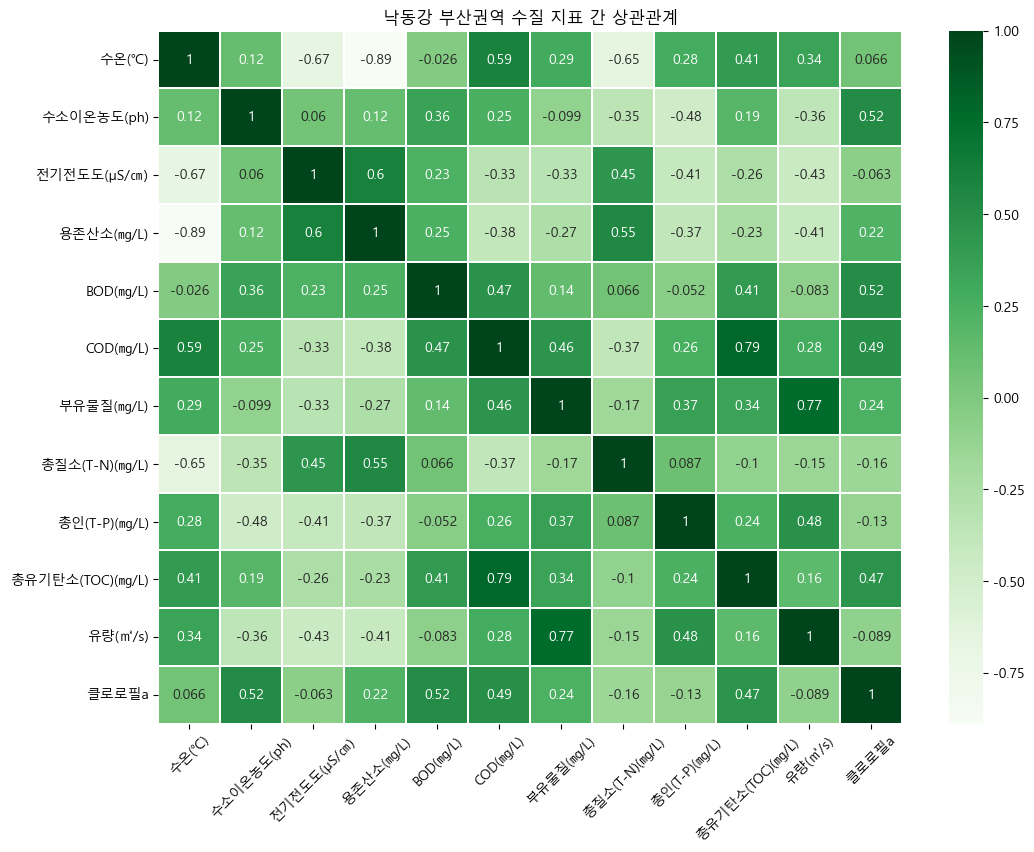

In [54]:
plt.figure(figsize=(12, 9)) 
sb.heatmap(wd, annot=True, linewidths=0.3, cmap='Greens')
plt.xticks(rotation=45)
plt.title("낙동강 부산권역 수질 지표 간 상관관계")
plt.show()

In [55]:
### 월 분리
waterDF['월'] = waterDF['일자'].dt.month
waterDF

,총량지점명,일자,수온(℃),수소이온농도(ph),전기전도도(μS/㎝),용존산소(㎎/L),BOD(㎎/L),COD(㎎/L),부유물질(㎎/L),총질소(T-N)(㎎/L),총인(T-P)(㎎/L),총유기탄소(TOC)(㎎/L),유량(㎥/s),클로로필a,월
0,물금,2021-01-04,4.6,7.5,437.0,13.1,1.7,5.1,2.4,3.223,0.025,3.8,29.555,12.4,1
1,물금,2021-01-11,2.8,7.3,461.0,14.3,2.0,5.4,4.0,3.268,0.031,4.0,28.599,19.4,1
2,물금,2021-01-26,5.1,7.2,470.0,15.6,2.1,6.0,7.6,3.416,0.026,4.6,74.897,47.3,1
3,물금,2021-01-18,3.1,7.3,463.0,15.2,2.2,5.9,6.4,3.327,0.032,4.4,47.190,33.2,1
4,물금,2021-02-16,6.6,8.4,451.0,12.1,2.8,6.6,12.4,3.489,0.027,5.0,72.735,50.4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,금곡,2025-09-23,25.4,7.7,285.0,7.8,1.3,6.9,6.4,1.928,0.055,3.6,357.260,17.4,9
402,금곡,2025-09-09,28.6,8.6,219.0,7.6,1.7,8.6,9.6,1.579,0.059,6.1,340.400,52.6,9
403,금곡,2025-10-13,23.3,8.4,288.0,9.0,1.6,7.0,7.6,1.858,0.041,3.4,443.810,39.5,10
404,금곡,2025-10-27,19.0,7.8,192.0,9.5,1.1,6.4,6.4,2.719,0.082,3.2,443.180,20.4,10


In [56]:
# 6-9월 추출
summerDF = waterDF[waterDF['월'].between(6, 9)]
summerDF

,총량지점명,일자,수온(℃),수소이온농도(ph),전기전도도(μS/㎝),용존산소(㎎/L),BOD(㎎/L),COD(㎎/L),부유물질(㎎/L),총질소(T-N)(㎎/L),총인(T-P)(㎎/L),총유기탄소(TOC)(㎎/L),유량(㎥/s),클로로필a,월
20,물금,2021-06-01,24.3,8.4,295.0,9.2,1.9,6.0,4.0,2.197,0.016,4.2,311.005,24.1,6
21,물금,2021-06-22,26.7,8.7,272.0,9.0,3.0,7.0,6.0,1.717,0.022,4.8,353.580,30.8,6
22,물금,2021-06-14,25.7,8.1,290.0,8.7,1.8,6.6,6.4,1.886,0.047,4.3,130.690,39.4,6
23,물금,2021-06-08,26.9,8.7,291.0,10.0,2.5,7.1,5.6,1.933,0.015,4.5,191.250,25.9,6
24,물금,2021-07-12,26.2,7.2,135.0,7.7,1.1,7.9,30.0,2.310,0.084,5.1,2009.616,12.1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,금곡,2025-08-18,30.7,7.9,166.0,9.0,2.7,6.5,6.0,2.524,0.093,3.9,418.950,27.3,8
399,금곡,2025-09-01,30.4,8.9,188.0,8.9,1.8,8.1,10.0,1.609,0.054,3.4,307.440,38.1,9
400,금곡,2025-09-15,28.8,8.6,275.0,9.7,2.2,8.3,7.2,1.758,0.055,3.9,184.660,48.9,9
401,금곡,2025-09-23,25.4,7.7,285.0,7.8,1.3,6.9,6.4,1.928,0.055,3.6,357.260,17.4,9


In [57]:
# 추출 결과 확인
summerDF['월'].value_counts().sort_index()

월
6    39
7    34
8    32
9    37
Name: count, dtype: int64

In [59]:
summerDF.describe(include='number')

,수온(℃),수소이온농도(ph),전기전도도(μS/㎝),용존산소(㎎/L),BOD(㎎/L),COD(㎎/L),부유물질(㎎/L),총질소(T-N)(㎎/L),총인(T-P)(㎎/L),총유기탄소(TOC)(㎎/L),유량(㎥/s),클로로필a,월
count,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,142.000000
mean,26.909286,7.871429,223.771429,8.201429,1.951429,6.845714,10.622857,1.970179,0.056457,4.400000,586.976107,23.067143,7.471831
std,2.561640,0.672725,72.049977,0.898198,0.774549,1.109759,10.878983,0.513912,0.029535,0.792864,652.057249,15.831480,1.152817
min,21.800000,6.500000,118.000000,6.600000,0.600000,4.600000,1.200000,0.804000,0.015000,2.100000,121.057000,2.900000,6.000000
25%,25.000000,7.400000,170.000000,7.500000,1.375000,6.100000,5.600000,1.576500,0.033000,3.800000,211.051750,10.300000,6.000000
50%,26.600000,7.850000,206.000000,8.100000,1.800000,6.750000,8.000000,2.019500,0.049500,4.300000,359.459000,20.350000,7.000000
75%,29.100000,8.400000,272.000000,8.800000,2.500000,7.325000,11.700000,2.307750,0.073250,4.800000,650.100000,29.575000,9.000000
max,32.000000,9.200000,480.000000,11.400000,4.400000,11.600000,100.800000,3.567000,0.153000,7.000000,3968.940000,95.500000,9.000000


In [60]:
numDF = summerDF.select_dtypes(include='number')
numDF.describe().T

,count,mean,std,min,25%,50%,75%,max
수온(℃),140.0,26.909286,2.561640,21.800,25.00000,26.6000,29.10000,32.000
수소이온농도(ph),140.0,7.871429,0.672725,6.500,7.40000,7.8500,8.40000,9.200
전기전도도(μS/㎝),140.0,223.771429,72.049977,118.000,170.00000,206.0000,272.00000,480.000
용존산소(㎎/L),140.0,8.201429,0.898198,6.600,7.50000,8.1000,8.80000,11.400
BOD(㎎/L),140.0,1.951429,0.774549,0.600,1.37500,1.8000,2.50000,4.400
COD(㎎/L),140.0,6.845714,1.109759,4.600,6.10000,6.7500,7.32500,11.600
부유물질(㎎/L),140.0,10.622857,10.878983,1.200,5.60000,8.0000,11.70000,100.800
총질소(T-N)(㎎/L),140.0,1.970179,0.513912,0.804,1.57650,2.0195,2.30775,3.567
총인(T-P)(㎎/L),140.0,0.056457,0.029535,0.015,0.03300,0.0495,0.07325,0.153
총유기탄소(TOC)(㎎/L),140.0,4.400000,0.792864,2.100,3.80000,4.3000,4.80000,7.000


In [62]:
summerDF.isna().sum().sort_values(ascending=False)

수온(℃)              2
수소이온농도(ph)         2
전기전도도(μS/㎝)        2
용존산소(㎎/L)          2
BOD(㎎/L)           2
COD(㎎/L)           2
부유물질(㎎/L)          2
총질소(T-N)(㎎/L)      2
총인(T-P)(㎎/L)       2
총유기탄소(TOC)(㎎/L)    2
유량(㎥/s)            2
클로로필a              2
총량지점명              0
일자                 0
월                  0
dtype: int64

In [ ]:
num_cols = [
    '수온', '수소이온농도(ph)', '전기전도도', '용존산소',
    'BOD', 'COD', '부유물질',
    '총질소(T-N)', '총인(T-P)',
    '총유기탄소(TOC)', '유량', '클로로필a'
]

summer_num = summerDF[num_cols]
summer_num.describe().T

,count,mean,std,min,25%,50%,75%,max
수온(℃),140.0,26.909286,2.561640,21.800,25.00000,26.6000,29.10000,32.000
수소이온농도(ph),140.0,7.871429,0.672725,6.500,7.40000,7.8500,8.40000,9.200
전기전도도(μS/㎝),140.0,223.771429,72.049977,118.000,170.00000,206.0000,272.00000,480.000
용존산소(㎎/L),140.0,8.201429,0.898198,6.600,7.50000,8.1000,8.80000,11.400
BOD(㎎/L),140.0,1.951429,0.774549,0.600,1.37500,1.8000,2.50000,4.400
COD(㎎/L),140.0,6.845714,1.109759,4.600,6.10000,6.7500,7.32500,11.600
부유물질(㎎/L),140.0,10.622857,10.878983,1.200,5.60000,8.0000,11.70000,100.800
총질소(T-N)(㎎/L),140.0,1.970179,0.513912,0.804,1.57650,2.0195,2.30775,3.567
총인(T-P)(㎎/L),140.0,0.056457,0.029535,0.015,0.03300,0.0495,0.07325,0.153
총유기탄소(TOC)(㎎/L),140.0,4.400000,0.792864,2.100,3.80000,4.3000,4.80000,7.000


In [66]:
corrDF = summerDF[num_cols].dropna()
corrDF

,수온(℃),수소이온농도(ph),전기전도도(μS/㎝),용존산소(㎎/L),BOD(㎎/L),COD(㎎/L),부유물질(㎎/L),총질소(T-N)(㎎/L),총인(T-P)(㎎/L),총유기탄소(TOC)(㎎/L),유량(㎥/s),클로로필a
20,24.3,8.4,295.0,9.2,1.9,6.0,4.0,2.197,0.016,4.2,311.005,24.1
21,26.7,8.7,272.0,9.0,3.0,7.0,6.0,1.717,0.022,4.8,353.580,30.8
22,25.7,8.1,290.0,8.7,1.8,6.6,6.4,1.886,0.047,4.3,130.690,39.4
23,26.9,8.7,291.0,10.0,2.5,7.1,5.6,1.933,0.015,4.5,191.250,25.9
24,26.2,7.2,135.0,7.7,1.1,7.9,30.0,2.310,0.084,5.1,2009.616,12.1
...,...,...,...,...,...,...,...,...,...,...,...,...
398,30.7,7.9,166.0,9.0,2.7,6.5,6.0,2.524,0.093,3.9,418.950,27.3
399,30.4,8.9,188.0,8.9,1.8,8.1,10.0,1.609,0.054,3.4,307.440,38.1
400,28.8,8.6,275.0,9.7,2.2,8.3,7.2,1.758,0.055,3.9,184.660,48.9
401,25.4,7.7,285.0,7.8,1.3,6.9,6.4,1.928,0.055,3.6,357.260,17.4


In [ ]:
# 두 변수가 “직선 관계”로 얼마나 같이 움직이는지를 측정 : 값 자체
corrDF.corr(method='pearson')['클로로필a'].sort_values(ascending=False)

클로로필a              1.000000
수소이온농도(ph)         0.650831
COD(㎎/L)           0.518806
BOD(㎎/L)           0.509141
수온(℃)              0.405091
용존산소(㎎/L)          0.342443
전기전도도(μS/㎝)        0.300826
총유기탄소(TOC)(㎎/L)    0.293216
부유물질(㎎/L)          0.012780
유량(㎥/s)           -0.301475
총인(T-P)(㎎/L)      -0.441830
총질소(T-N)(㎎/L)     -0.481547
Name: 클로로필a, dtype: float64

In [ ]:
# 